In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set(); sns.set_theme(style='white')

import random as rd
import datetime

from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller, acf, pacf, arma_order_select_ic
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm

import scipy.stats as scs

from pandas.plotting import autocorrelation_plot

import warnings; warnings.filterwarnings("ignore")

In [2]:
sales = pd.read_csv("./data/sales_train.csv")
item_cat = pd.read_csv("./data/item_categories.csv")
item = pd.read_csv("./data/items.csv")
shops = pd.read_csv("./data/shops.csv")
test = pd.read_csv("./data/test.csv")

In [3]:
sales.shape

(2935849, 6)

In [4]:
item.shape

(22170, 3)

In [5]:
item_cat.shape

(84, 2)

In [6]:
shops.shape

(60, 2)

In [7]:
test.shape

(214200, 3)

In [8]:
sales.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


In [9]:
item_cat.head()

,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1
2,Аксессуары - PS3,2
3,Аксессуары - PS4,3
4,Аксессуары - PSP,4


In [10]:
item.head()

,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40
4,***КОРОБКА (СТЕКЛО) D,4,40


In [11]:
shops.head()

,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1
2,"Адыгея ТЦ ""Мега""",2
3,"Балашиха ТРК ""Октябрь-Киномир""",3
4,"Волжский ТЦ ""Волга Молл""",4


In [12]:
test.head()

,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233
3,3,5,5232
4,4,5,5268


In [13]:
sales["date"] = sales["date"].apply(lambda x: datetime.datetime.strptime(x, "%d.%m.%Y"))
sales.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,2013-01-02,0,59,22154,999.00,1.0
1,2013-01-03,0,25,2552,899.00,1.0
2,2013-01-05,0,25,2552,899.00,-1.0
3,2013-01-06,0,25,2554,1709.05,1.0
4,2013-01-15,0,25,2555,1099.00,1.0


In [14]:
sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2935849 entries, 0 to 2935848
Data columns (total 6 columns):
 #   Column          Dtype         
---  ------          -----         
 0   date            datetime64[ns]
 1   date_block_num  int64         
 2   shop_id         int64         
 3   item_id         int64         
 4   item_price      float64       
 5   item_cnt_day    float64       
dtypes: datetime64[ns](1), float64(2), int64(3)
memory usage: 134.4 MB


In [15]:
monthly_sales = sales.groupby([
    "date_block_num",
    "shop_id",
    "item_id"
])[
    "date",
    "item_price",
    "item_cnt_day"
].agg({
    "date": [
        "min", "max"
    ],
    "item_price": "mean",
    "item_cnt_day": "sum"
})

In [16]:
monthly_sales.head()

date            item_price item_cnt_day
                                      min        max       mean          sum
date_block_num shop_id item_id                                              
0              0       32      2013-01-03 2013-01-31      221.0          6.0
                       33      2013-01-03 2013-01-28      347.0          3.0
                       35      2013-01-31 2013-01-31      247.0          1.0
                       43      2013-01-31 2013-01-31      221.0          1.0
                       51      2013-01-13 2013-01-31      128.5          2.0

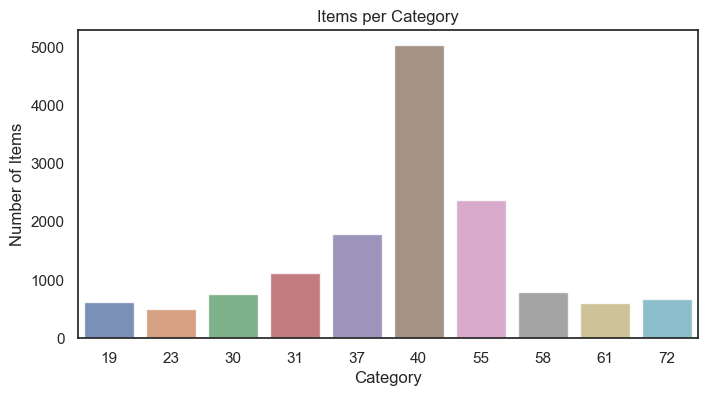

In [17]:
x = item.groupby(["item_category_id"]).count()
x = x.sort_values(by="item_id", ascending=False)
x = x.iloc[0:10].reset_index()

plt.figure(figsize=(8, 4))
ax = sns.barplot(x["item_category_id"], x["item_id"], alpha=0.8)
plt.title("Items per Category")
plt.ylabel("Number of Items", fontsize=12)
plt.xlabel("Category", fontsize=12)
plt.show()

In [18]:
item_cat[item_cat["item_category_id"] == 40]

,item_category_name,item_category_id
40,Кино - DVD,40


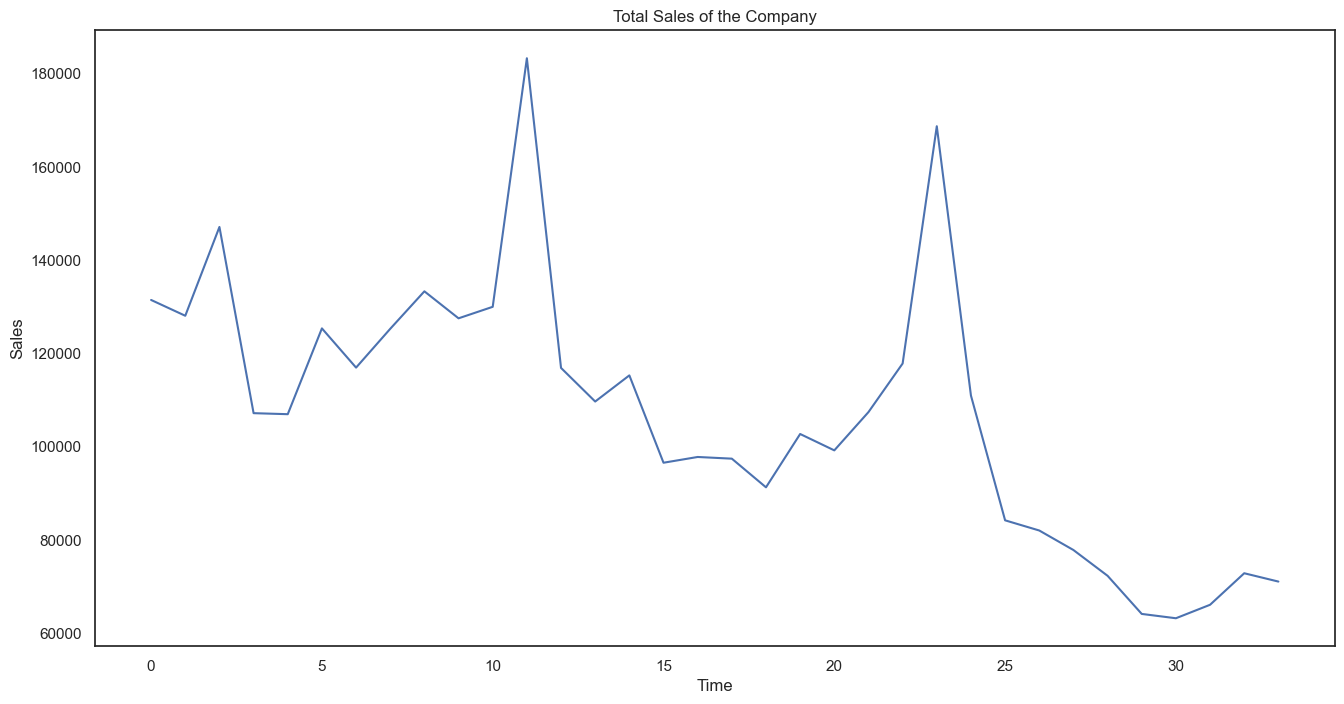

In [19]:
ts = sales.groupby(["date_block_num"])["item_cnt_day"].sum()
ts.astype("float")

plt.figure(figsize=(16, 8))
plt.title("Total Sales of the Company")
plt.xlabel("Time")
plt.ylabel("Sales")
plt.plot(ts)
plt.show()

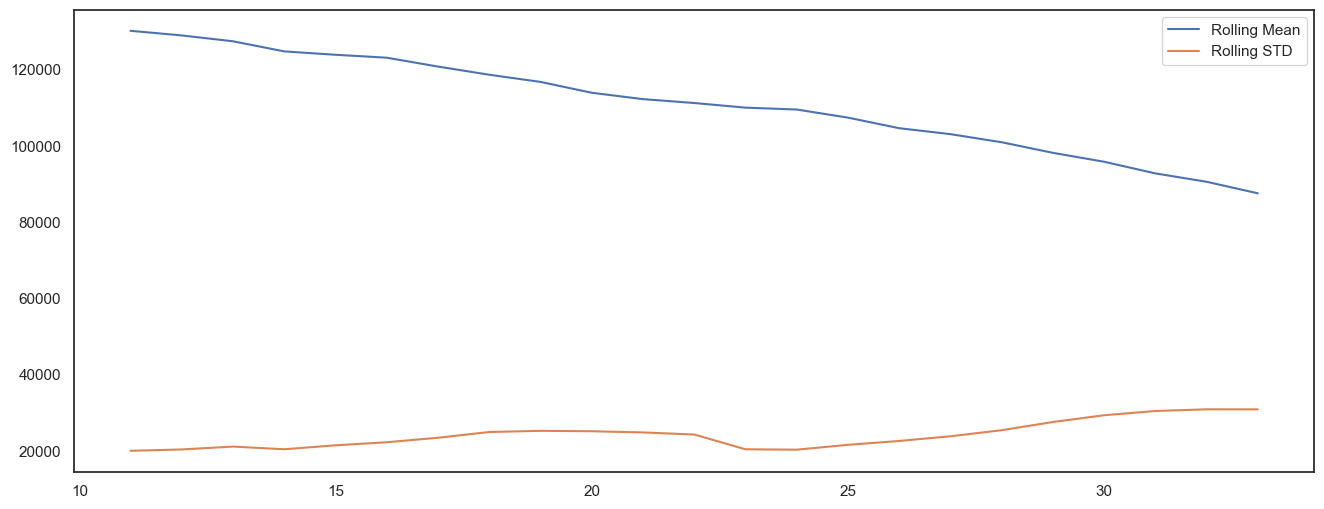

In [20]:
plt.figure(figsize=(16, 6))
plt.plot(ts.rolling(window=12, center=False).mean(), label="Rolling Mean")
plt.plot(ts.rolling(window=12, center=False).std(), label="Rolling STD")
plt.legend()
plt.show()

<Figure size 1600x1200 with 0 Axes>

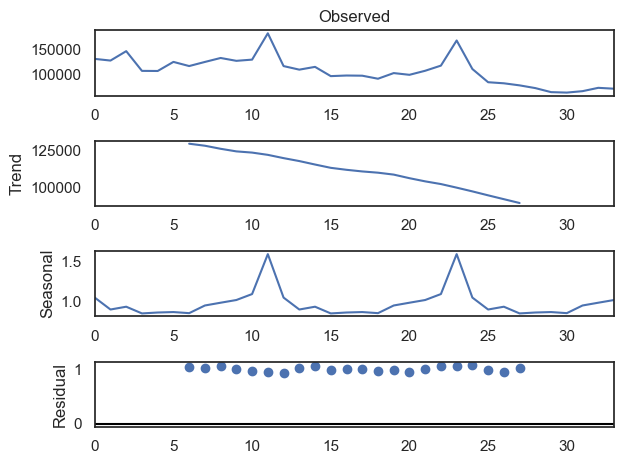

In [21]:
res = sm.tsa.seasonal_decompose(ts.values, period=12, model="multiplicative")
plt.figure(figsize=(16, 12))
res.plot()
plt.show()

<Figure size 1600x1200 with 0 Axes>

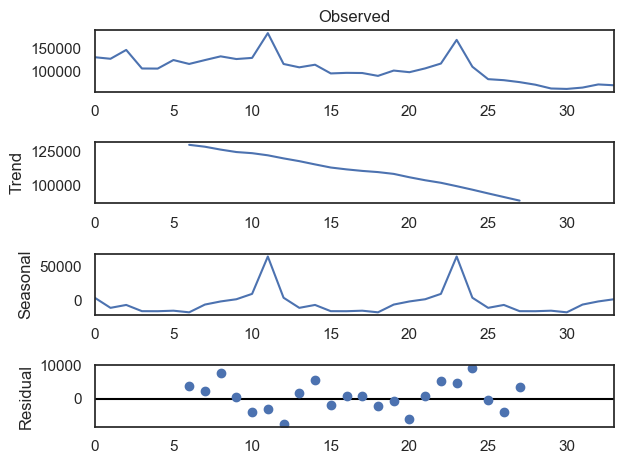

In [22]:
res = sm.tsa.seasonal_decompose(ts.values, period=12, model="additive")
plt.figure(figsize=(16, 12))
res.plot()
plt.show()

In [23]:
def test_stationarity(timeseries):
    print("Results of Dickey-Fuller Test: ")
    dftest = adfuller(timeseries, autolag="AIC")
    dfoutput = pd.Series(dftest[0:4], index=[
        "Test Statistic", "p-value", 
        "Number of Lags Used", 
        "Number of Observations Used"
    ])
    for key, value in dftest[4].items():
        dfoutput[f"Critical Value {key}"] = value
    print(dfoutput)

In [24]:
test_stationarity(ts)

Results of Dickey-Fuller Test: 
Test Statistic                 -2.395704
p-value                         0.142953
Number of Lags Used             0.000000
Number of Observations Used    33.000000
Critical Value 1%              -3.646135
Critical Value 5%              -2.954127
Critical Value 10%             -2.615968
dtype: float64


In [25]:
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return pd.Series(diff)

In [26]:
def inverse_difference(last_ob, value):
    return value + last_ob

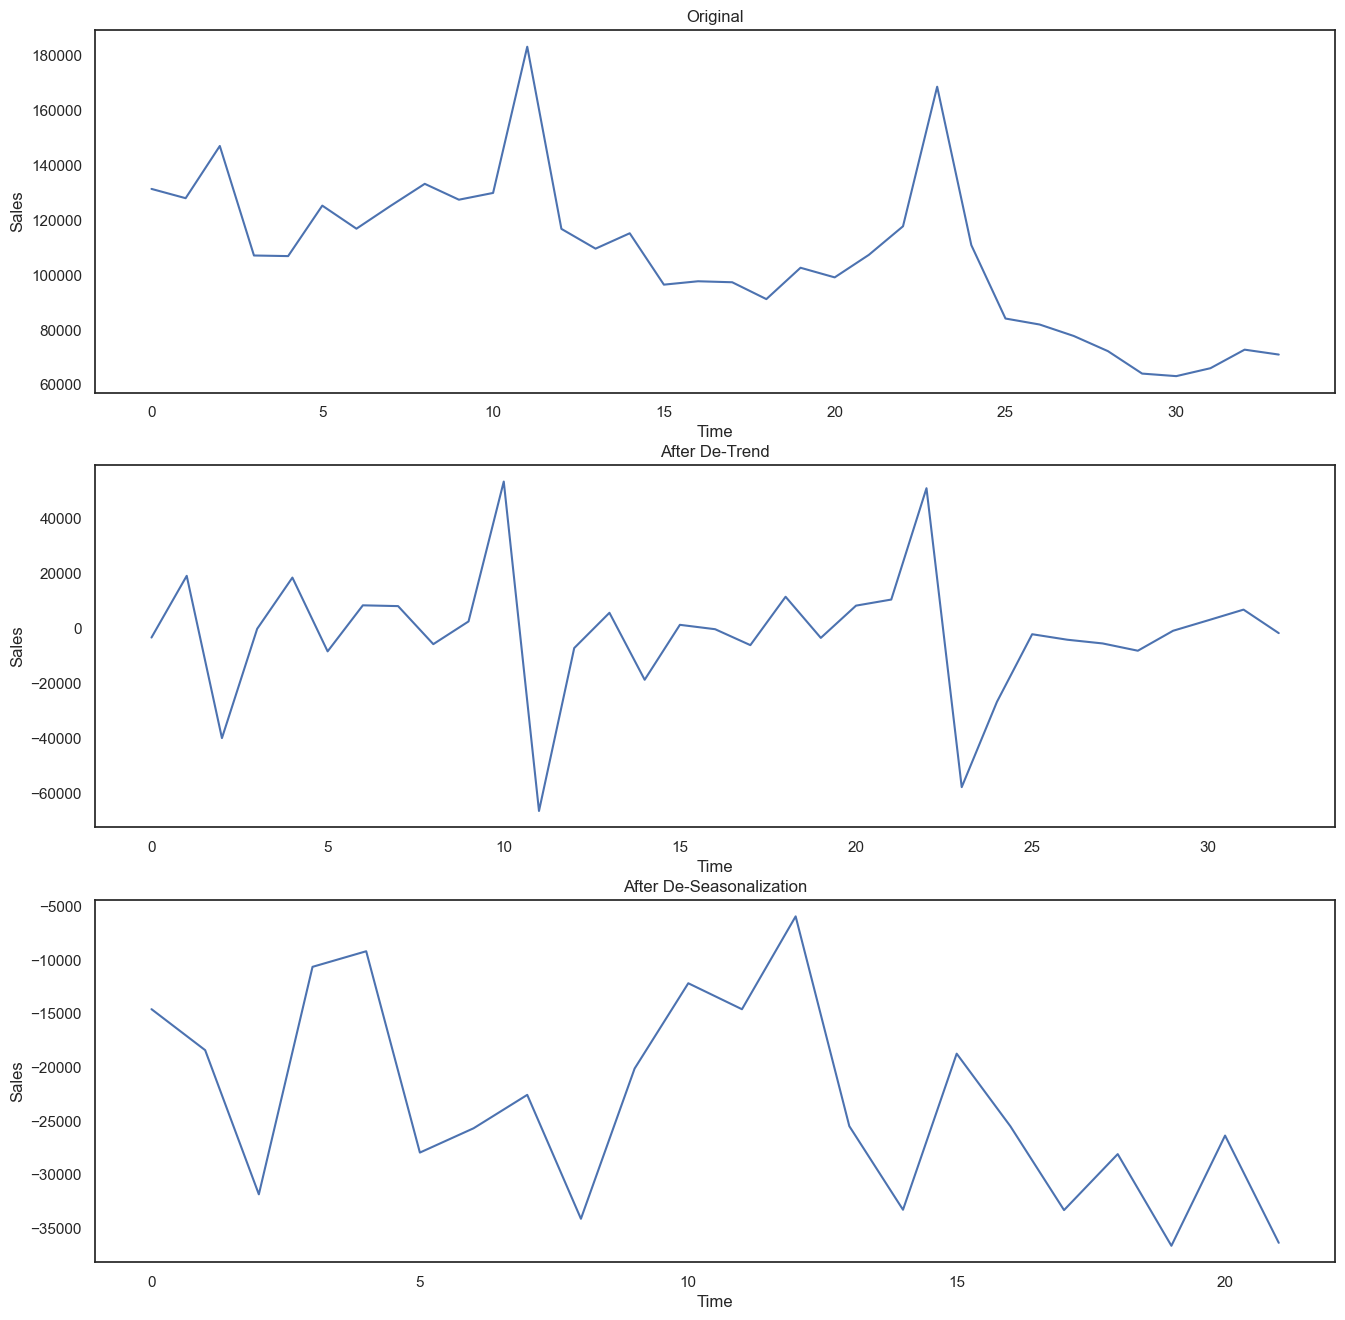

In [27]:
ts = sales.groupby(["date_block_num"])["item_cnt_day"].sum()
# ts.asytpe("float")

plt.figure(figsize=(16, 16))
plt.subplot(311)
plt.title("Original")
plt.xlabel("Time")
plt.ylabel("Sales")
plt.plot(ts)

plt.subplot(312)
plt.title("After De-Trend")
plt.xlabel("Time")
plt.ylabel("Sales")
plt.plot(difference(ts))

plt.subplot(313)
plt.title("After De-Seasonalization")
plt.xlabel("Time")
plt.ylabel("Sales")
plt.plot(difference(ts, 12))

plt.show()

In [28]:
test_stationarity(difference(ts))

Results of Dickey-Fuller Test: 
Test Statistic                -1.363622e+01
p-value                        1.686395e-25
Number of Lags Used            1.000000e+01
Number of Observations Used    2.200000e+01
Critical Value 1%             -3.769733e+00
Critical Value 5%             -3.005426e+00
Critical Value 10%            -2.642501e+00
dtype: float64


In [29]:
test_stationarity(difference(ts, 12))

Results of Dickey-Fuller Test: 
Test Statistic                 -3.270101
p-value                         0.016269
Number of Lags Used             0.000000
Number of Observations Used    21.000000
Critical Value 1%              -3.788386
Critical Value 5%              -3.013098
Critical Value 10%             -2.646397
dtype: float64


In [30]:
def tsplot(y, lags=None, figsize=(10, 8), style="bmh", title=""):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):
        fig = plt.figure(figsize=figsize)
        layout = (3, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        qq_ax = plt.subplot2grid(layout, (2, 0))
        pp_ax = plt.subplot2grid(layout, (2, 1))
        
        y.plot(ax=ts_ax)
        ts_ax.set_title(title)
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.5)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.5)
        sm.qqplot(y, line="s", ax=qq_ax)
        qq_ax.set_title("QQ Plot")
        
        scs.probplot(y, sparams=(y.mean(), y.std()), plot=pp_ax)
        plt.tight_layout()

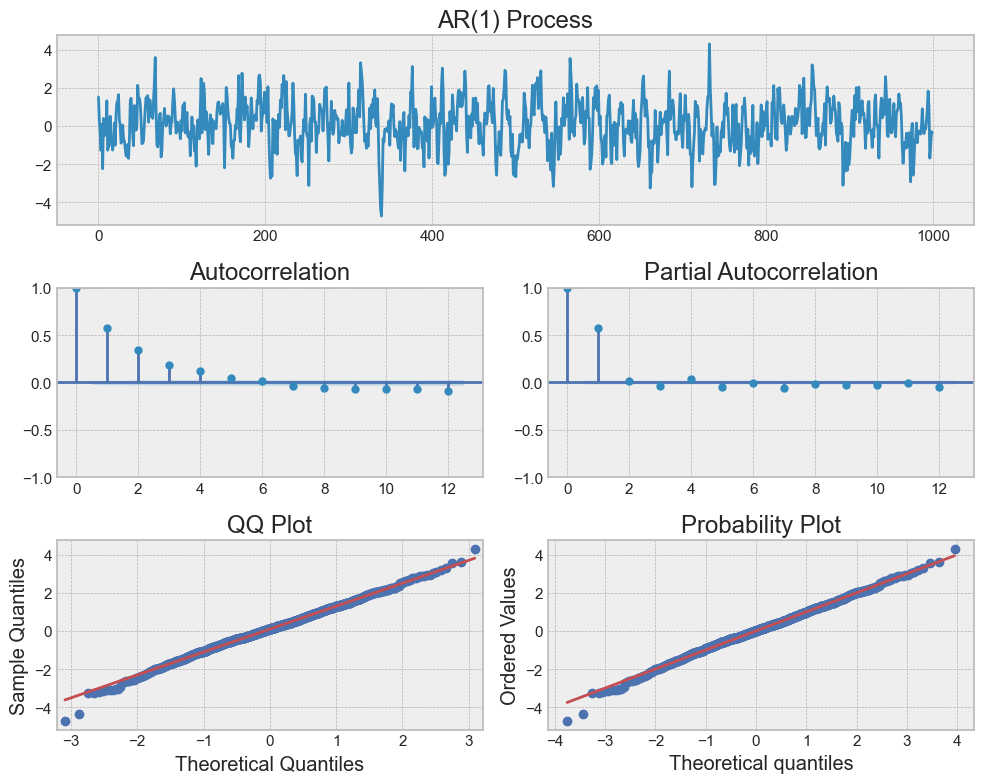

In [31]:
np.random.seed(1)
n_samples = int(1000)
a = 0.6
x = w = np.random.normal(size=n_samples)

for t in range(n_samples):
    x[t] = a * x[t-1] + w[t]

limit = 12
tsplot(x, lags=limit, title="AR(1) Process")

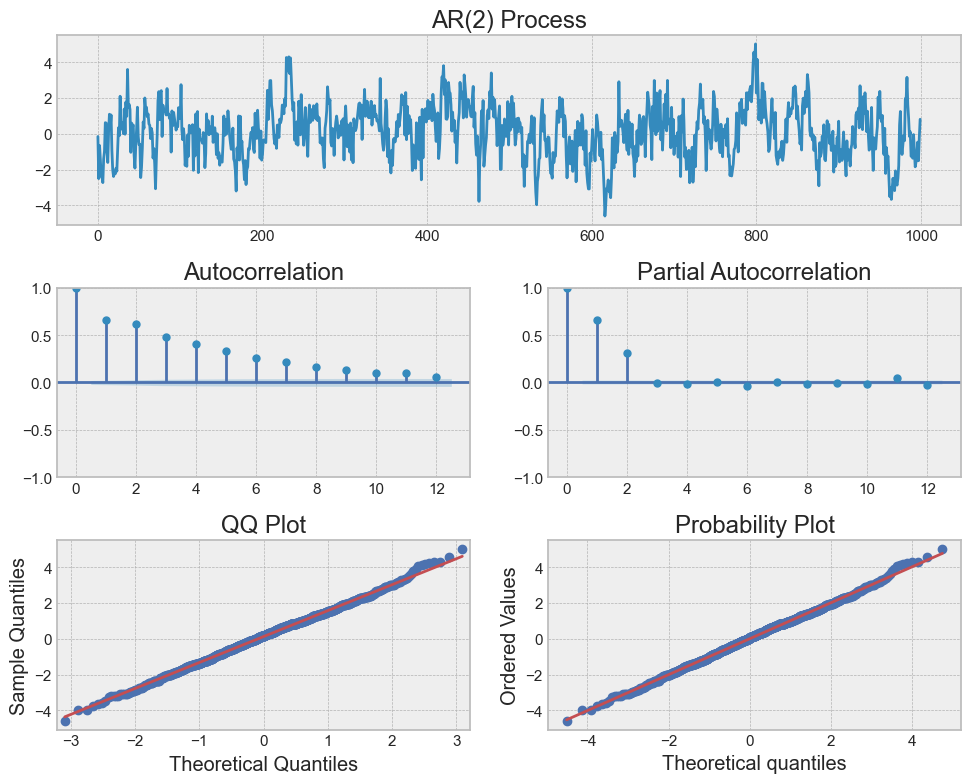

In [32]:
n = int(1000)
alphas = np.array([.444, .333])
betas = np.array([0.])

ar = np.r_[1, -alphas]
ma = np.r_[1, betas]

ar2 = smt.arma_generate_sample(ar=ar, ma=ma, nsample=n)
tsplot(ar2, lags=12, title="AR(2) Process")

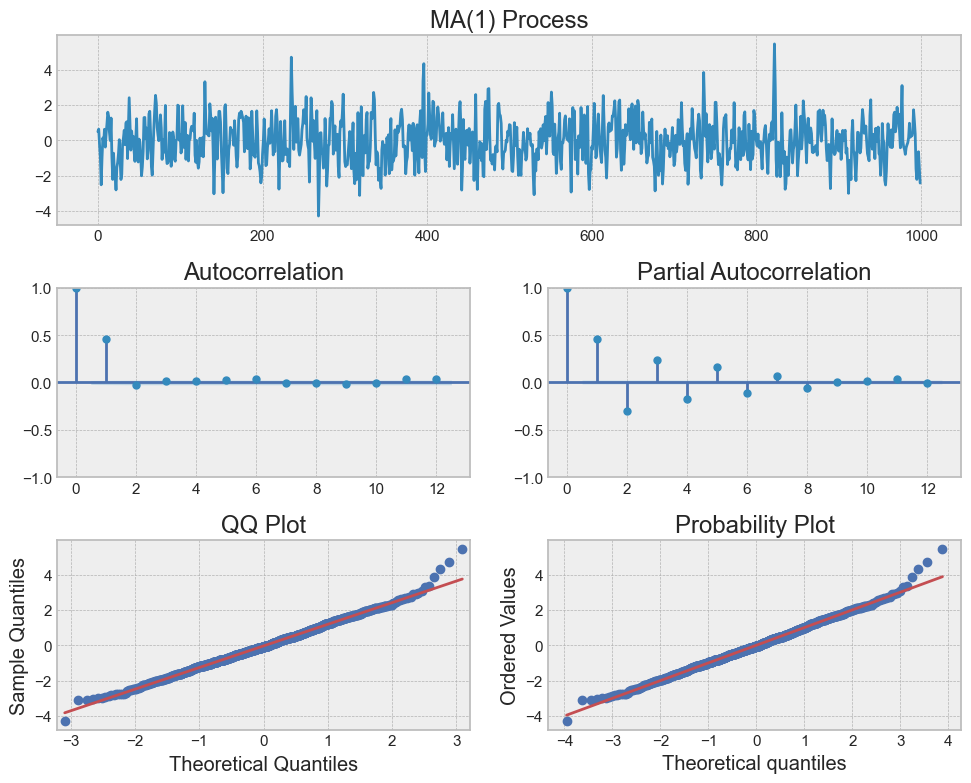

In [33]:
n = int(1000)

alphas = np.array([0.])
betas = np.array([0.8])

ar = np.r_[1, -alphas]
ma = np.r_[1, betas]

ma1 = smt.arma_generate_sample(ar=ar, ma=ma, nsample=n)
limit = 12

tsplot(ma1, lags=limit, title="MA(1) Process")

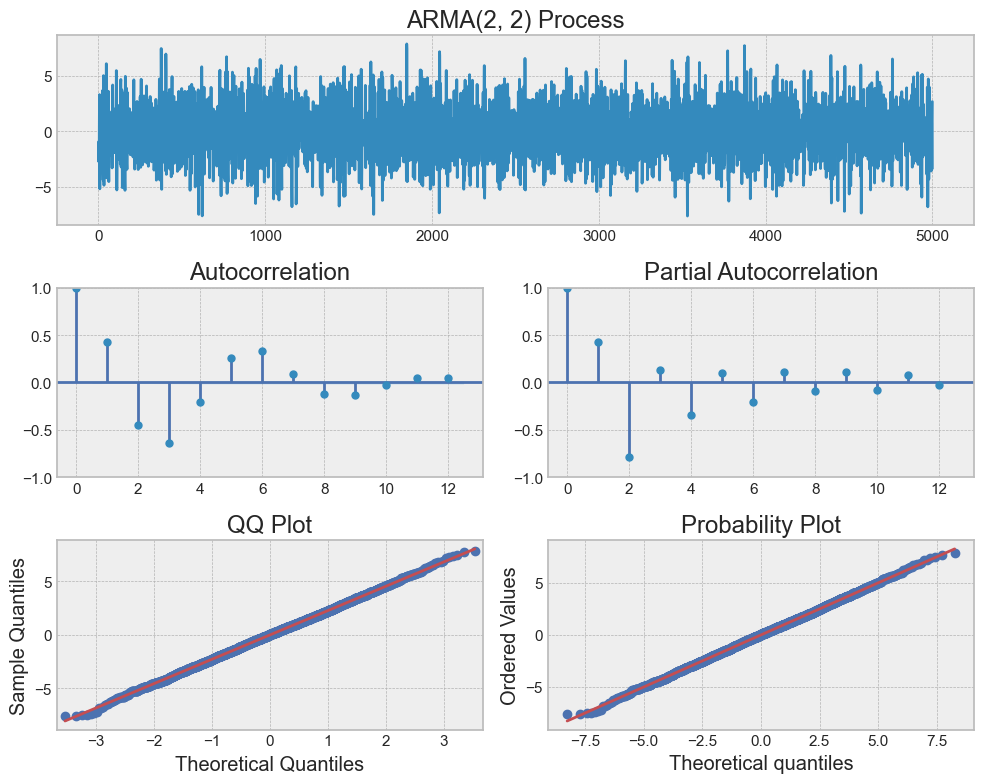

In [34]:
max_lag = 12

n = int(5000)
burn = int(n/10)

alphas = np.array([0.8, -0.65])
betas = np.array([0.5, -0.7])

ar = np.r_[1, -alphas]
ma = np.r_[1, betas]

ar2ma2 = smt.arma_generate_sample(ar=ar, ma=ma, nsample=n, burnin=burn)

tsplot(ar2ma2, lags=max_lag, title="ARMA(2, 2) Process")